##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [38]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
orig_df = pd.read_csv('datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [40]:
df = pd.read_csv('datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [41]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [42]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [43]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


Ans: Column explanation
* 'X' and 'Y': These columns likely represent the latitude and longitude, which provide the location information of the reported events.
* 'Time': This column represents the hour of the day when the event was reported.
* 'DayOfWeek': This column represents the day of the week when the event was reported.
* 'Area_Command': This column appears to be a code representing the police designation of the bureau of operation.
* 'NIBRSOffenseCode': This column contains a classification code for the type of crime committed.
* 'VictimCount': This column represents the number of persons involved in the incident.

Input and Target variables
* Input Variables: The input features for the predictive model are 'X' (latitude), 'Y' (longitude), 'Time' (hour of the day), 'DayOfWeek' (day of the week), 'Area_Command' (police bureau code), and 'NIBRSOffenseCode' (crime classification code).
* Target Variable: The target variable is 'VictimCount', which represents the number of persons involved in the incident.

Range of Values in Each Column:

* X Range: (-116.0, -114.6255705)

* Y Range: (35.0684190000001, 37.0000000000001)

* Area_Command Range: (0, 11)

* NIBRSOffenseCode Range: (0, 2)

* DayOfWeek Range: (0, 6)

* Time Range: (0, 23)

We need to Scale and Normalize our data.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
    
print(df.head())

# Input Variables (Features)
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]

# Target Variable
y = df['VictimCount']

# Scale and Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the range of scaled and normalized values in each column
print("\nRange of Scaled and Normalized Values in Each Column:")
for i, column in enumerate(X.columns):
    column_range = (X_scaled[:, i].min(), X_scaled[:, i].max())
    print(f"\n{column} Range: {column_range}")

# Create custom PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train.values)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test.values)

# Use the custom Dataset to create DataLoader objects
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# Define batch size
batch_size = 48

# Create DataLoader objects for training and testing using the custom Dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check the shape of the batched data by iterating over one dataset
for batch in train_loader:
    X_batch, y_batch = batch
    print("\nBatch Input Shape:", X_batch.shape)
    print("Batch Target Shape:", y_batch.shape)
    break  # Print the shape of the first batch in the training DataLoader


            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  

Range of Scaled and Normalized Values in Each Column:

X Range: (-8.314509866451008, 5.278993120059608)

Y Range: (-9.094050765999022, 7.247219811387703)

Area_Command Range: (-1.3085019826145616, 2.30961364573009)

NIBRSOffenseCode Range: (-2.719641466102106, 3.263569759322527)

DayOfWeek Range: (-1.5521508752899003, 1.5710795445007526)

Time Range: (-1.5989985217296396, 1.6740324329434901)

Batch Input Shape: torch.Size([48, 6])

## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

Ans:
* The proper loss function is the Mean Squared Error.
* The size of the predicted output is 1.
* Choice of Architecture: A Neural Network with 1 input layer, 4 hidden layer and 1 output layer. The architecture can capture the complex relations in the data and the number of hidden layers and the size of each layer are hyperparameters can be adjusted to achieve the best model performance.
* Optimizer: Adam optimizer with a learning rate of 0.0001

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

Ans:
* Number of Classes in Output Data: In regression, the output is continuous, representing a numerical value (e.g., predicting a victim count). In classification, the output is discrete and represents classes or categories. To find the number of classes in the output data, you can use the following code: num_classes = len(df['VictimCount'].unique()) This will give you the number of unique classes in the 'VictimCount' column, which corresponds to the number of classes in your classification problem.
* Architecture Differences: In regression, the architecture typically consists of a single output neuron, as you are predicting a single continuous value. In classification, the architecture may have multiple output neurons, each corresponding to a different class. Here we have used 1 input layer, 2 hidden layers and 1 output layer.
* Loss Function Differences: In regression, you use mean squared error (MSE) as the loss function to measure the difference between predicted and actual numerical values. In classification, you typically use cross-entropy loss (e.g., torch.nn.CrossEntropyLoss()) as the loss function to measure the difference between predicted class probabilities and actual class labels.

In [45]:
criterion = torch.nn.MSELoss()
input_size = 6 
hidden_size = 64
output_size = 1

class RegressionModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc5 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc6 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

model = RegressionModel(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.view(outputs.shape)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            targets = targets.view(outputs.shape)
            test_loss += criterion(outputs, targets).item()

    test_loss /= len(test_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test MSE: {test_loss:.4f}')

Epoch [1/30], Test MSE: 0.0345
Epoch [2/30], Test MSE: 0.0584
Epoch [3/30], Test MSE: 0.0359
Epoch [4/30], Test MSE: 0.0313
Epoch [5/30], Test MSE: 0.0330
Epoch [6/30], Test MSE: 0.0696
Epoch [7/30], Test MSE: 0.0637
Epoch [8/30], Test MSE: 0.0682
Epoch [9/30], Test MSE: 0.0298
Epoch [10/30], Test MSE: 0.0357
Epoch [11/30], Test MSE: 0.0514
Epoch [12/30], Test MSE: 0.0470
Epoch [13/30], Test MSE: 0.0333
Epoch [14/30], Test MSE: 0.0635
Epoch [15/30], Test MSE: 0.0617
Epoch [16/30], Test MSE: 0.0330
Epoch [17/30], Test MSE: 0.0387
Epoch [18/30], Test MSE: 0.0425
Epoch [19/30], Test MSE: 0.0438
Epoch [20/30], Test MSE: 0.0328
Epoch [21/30], Test MSE: 0.0399
Epoch [22/30], Test MSE: 0.0418
Epoch [23/30], Test MSE: 0.0308
Epoch [24/30], Test MSE: 0.0393
Epoch [25/30], Test MSE: 0.0444
Epoch [26/30], Test MSE: 0.0396
Epoch [27/30], Test MSE: 0.0502
Epoch [28/30], Test MSE: 0.0423
Epoch [29/30], Test MSE: 0.0380
Epoch [30/30], Test MSE: 0.0272


In [80]:
num_classes = len(df['VictimCount'].unique())  # Number of classes
input_size = 6 
hidden_size = 128

# Define the model architecture for classification
class ClassificationModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = ClassificationModel(input_size, hidden_size, num_classes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')
    # Check if the current accuracy is the best so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
print(f'Best Test Accuracy: {best_accuracy:.2f}%')

Epoch [1/30], Test Accuracy: 3.64%
Epoch [2/30], Test Accuracy: 7.27%
Epoch [3/30], Test Accuracy: 18.18%
Epoch [4/30], Test Accuracy: 30.91%
Epoch [5/30], Test Accuracy: 50.91%
Epoch [6/30], Test Accuracy: 58.18%
Epoch [7/30], Test Accuracy: 61.82%
Epoch [8/30], Test Accuracy: 61.82%
Epoch [9/30], Test Accuracy: 60.00%
Epoch [10/30], Test Accuracy: 60.00%
Epoch [11/30], Test Accuracy: 60.00%
Epoch [12/30], Test Accuracy: 60.00%
Epoch [13/30], Test Accuracy: 54.55%
Epoch [14/30], Test Accuracy: 54.55%
Epoch [15/30], Test Accuracy: 54.55%
Epoch [16/30], Test Accuracy: 54.55%
Epoch [17/30], Test Accuracy: 54.55%
Epoch [18/30], Test Accuracy: 54.55%
Epoch [19/30], Test Accuracy: 54.55%
Epoch [20/30], Test Accuracy: 54.55%
Epoch [21/30], Test Accuracy: 54.55%
Epoch [22/30], Test Accuracy: 54.55%
Epoch [23/30], Test Accuracy: 54.55%
Epoch [24/30], Test Accuracy: 54.55%
Epoch [25/30], Test Accuracy: 54.55%
Epoch [26/30], Test Accuracy: 54.55%
Epoch [27/30], Test Accuracy: 54.55%
Epoch [28/30

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Ans:
* In tasks 3 and 4, I had the opportunity to work on both regression and classification problems using PyTorch. 
* The key distinction between the two lay in the nature of the output and the corresponding architecture and loss functions. 
* Task 3 involved regression, where the goal was to predict a continuous numerical value. For this, a simple neural network with a mean squared error loss function worked well. 
* In Task 4, we transitioned to classification, where the objective was to assign discrete categories to data points. This required a different model architecture with multiple output neurons and a cross-entropy loss function. 
* In comparing the results, the classification task performed notably better. This was primarily because classification tasks inherently offer a more suitable framework for the type of data being analyzed – crime incidents categorized into victim count groups. 
* The model was better equipped to discern classes and achieved higher accuracy, highlighting the importance of selecting the right problem formulation for the given dataset.

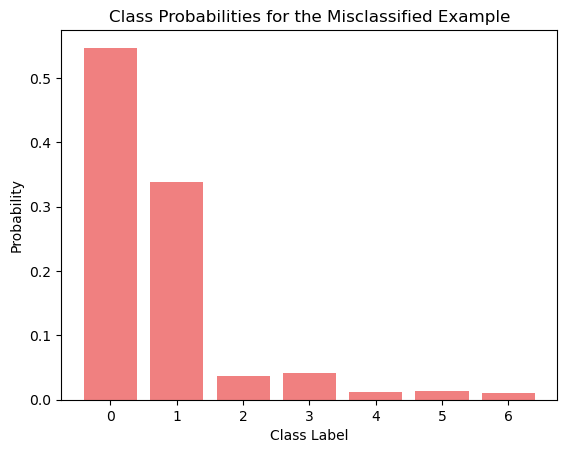

Correct Class Label: 3.0


In [47]:
import torch
import matplotlib.pyplot as plt

# Initialize variables to track misclassifications
misclassified_examples = []
misclassified_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)

        # Find misclassified examples
        misclassified_mask = predicted != targets
        misclassified_examples.extend(inputs[misclassified_mask])
        misclassified_labels.extend(targets[misclassified_mask])

# Randomly choose a misclassified example
import random
random_index = random.randint(0, len(misclassified_examples) - 1)
misclassified_example = misclassified_examples[random_index]
correct_label = misclassified_labels[random_index].item()

# Calculate class probabilities for the misclassified example
with torch.no_grad():
    misclassified_example = misclassified_example.unsqueeze(0)
    outputs = model(misclassified_example)
    class_probabilities = torch.softmax(outputs, dim=1).numpy()[0]

# Visualize class probabilities in a bar chart
class_labels = [str(i) for i in range(len(class_probabilities))]
plt.bar(class_labels, class_probabilities, color='lightcoral')
plt.xlabel('Class Label')
plt.ylabel('Probability')
plt.title('Class Probabilities for the Misclassified Example')
plt.show()

print(f"Correct Class Label: {correct_label}")

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


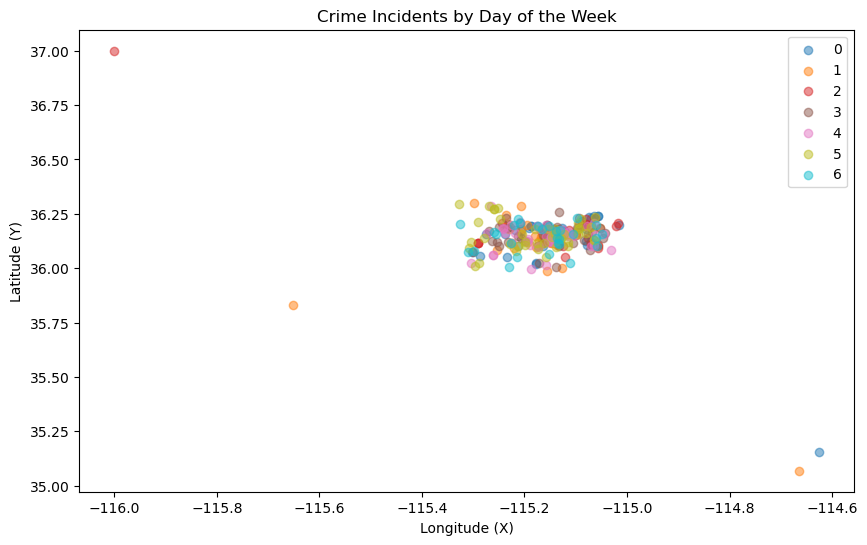

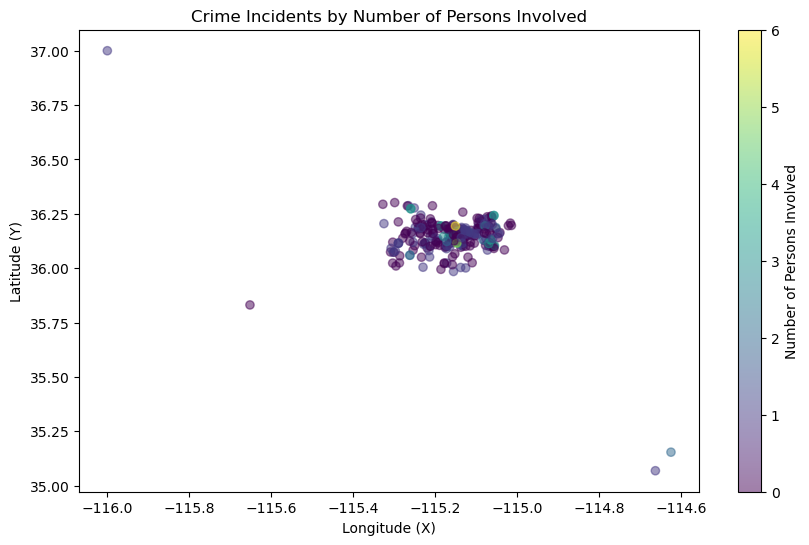

Number of Crimes Reported by Day of the Week:
0    40
1    37
2    32
3    44
4    51
5    43
6    28
Name: DayOfWeek, dtype: int64


In [48]:
# Create a scatter plot with different colors for each day of the week
plt.figure(figsize=(10, 6))
days_of_week = df['DayOfWeek'].unique()
colormap = plt.get_cmap('tab10', len(days_of_week))

for i, day in enumerate(days_of_week):
    day_data = df[df['DayOfWeek'] == day]
    plt.scatter(day_data['X'], day_data['Y'], c=[colormap(i)], label=day, alpha=0.5)

plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Day of the Week')
plt.legend()
plt.show()

# Create a scatter plot with different colors based on the number of persons involved
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', alpha=0.5)
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Number of Persons Involved')
plt.colorbar(label='Number of Persons Involved')
plt.show()

# Sort the number of crimes reported by the day of the week
crime_counts_by_day = df['DayOfWeek'].value_counts().sort_index()
most_frequent_day = crime_counts_by_day.idxmax()
print("Number of Crimes Reported by Day of the Week:")
print(crime_counts_by_day)